In [ ]:
# http://nbviewer.ipython.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter6_Priorities/Chapter6.ipynb

import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from pymc3 import summary, traceplot

%matplotlib inline


/Users/Leland/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [ ]:
df = pd.read_csv('CFB2014_scores.psv', delimiter='|')
df.drop('i_home',axis = 1, inplace = True)
df.drop('i_away', axis = 1, inplace = True)

In [203]:
#df = pd.read_csv('/Users/lelandlockhart/Desktop/results_2014.csv',delimiter = ",")

In [ ]:
df.head()

In [206]:
df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

home_team         away_team  home_score  away_score  i_home  i_away
0  Louisiana-Monroe       Wake Forest          17          10       0     110
1       Mississippi       Boise State          35          13       1      42
2           Rutgers  Washington State          41          38       2     105
3        Vanderbilt        Vanderbilt           7           7       3       3
4    South Carolina    South Carolina          28          28       4       4

In [207]:
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

team  i
0  Louisiana-Monroe  0
1       Mississippi  1
2           Rutgers  2
3        Vanderbilt  3
4    South Carolina  4

In [208]:
observed_home_score = df.home_score.values
observed_away_score = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_home = len(df.i_home.drop_duplicates())
num_away = len(df.i_away.unique())
num_games = len(home_team)

In [209]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
#att_starting_points = g.away_score.mean()
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())
#def_starting_points = g.away_score.mean()

In [210]:
df.head()

home_team         away_team  home_score  away_score  i_home  i_away
0  Louisiana-Monroe       Wake Forest          17          10       0     110
1       Mississippi       Boise State          35          13       1      42
2           Rutgers  Washington State          41          38       2     105
3        Vanderbilt        Vanderbilt           7           7       3       3
4    South Carolina    South Carolina          28          28       4       4

In [247]:
with pm.Model() as model:

    #hyperpriors
    home = pm.Normal('home', 10, tau=0.0001, testval = 10)
    #intercept = pm.Normal('intercept', 0, 1)
    #tau_att = pm.Normal('tau_att', 20, sd=1)
    #tau_def = pm.Normal('tau_def', 20, sd=1)
    #tau_att = pm.Uniform('tau_att',0,100)
    #tau_def = pm.Uniform('tau_def', 0,100)
    #tau_att = pm.Gamma('tau_att', .1, .1, testval=10)
    #tau_def = pm.Gamma('tau_def', .1, .1, testval=10)
    sd_att = pm.Uniform('sd_att', 0, 20)
    sd_tau = pm.Uniform('sd_tau', 0, 20)
    mu_att = pm.Normal('mu_att', 20, sd = 5, testval = 30)
    mu_def = pm.Normal('mu_def', 20, sd = 5, testval = 20)
    
    #team-specific parameters
    atts = pm.Normal("atts", mu=mu_att, sd=sd_att, shape=num_home, testval = att_starting_points.values)
    defs = pm.Normal("defs", mu=mu_def, sd=sd_tau, shape=num_away, testval = def_starting_points.values) 

    
    #home_theta = pm.exp(home + atts[home_team] + defs[away_team])
    #away_theta = pm.exp(atts[away_team] + defs[home_team])
    
    home_theta = home + atts[home_team] + defs[away_team]
    away_theta = atts[away_team] + defs[home_team]

    home_points = pm.Poisson('home_points', mu=home_theta, observed=observed_home_score)
    away_points = pm.Poisson('away_points', mu=away_theta, observed=observed_away_score)


In [248]:
with model:
    #start = pm.find_MAP()
    #step = pm.NUTS(scaling = start)
    step = pm.NUTS()
    #trace = pm.sample(11000, step, start = start, progressbar = True, njobs = 1)
    trace = pm.sample(110000, step, progressbar = True, njobs = 1)


 [-----------------100%-----------------] 110000 of 110000 complete in 92.6 sec

In [249]:
summary(trace)


home:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  10.000           0.000            0.000            [10.000, 10.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  10.000         10.000         10.000         10.000         10.000


sd_att_interval:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.000            0.000            0.000            [0.000, 0.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.000          0.000          0.000          0.000          0.000


sd_tau_interval:
 
  Mean             SD               MC Error         95% HPD interval
  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4e45710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a582d850>]], dtype=object)

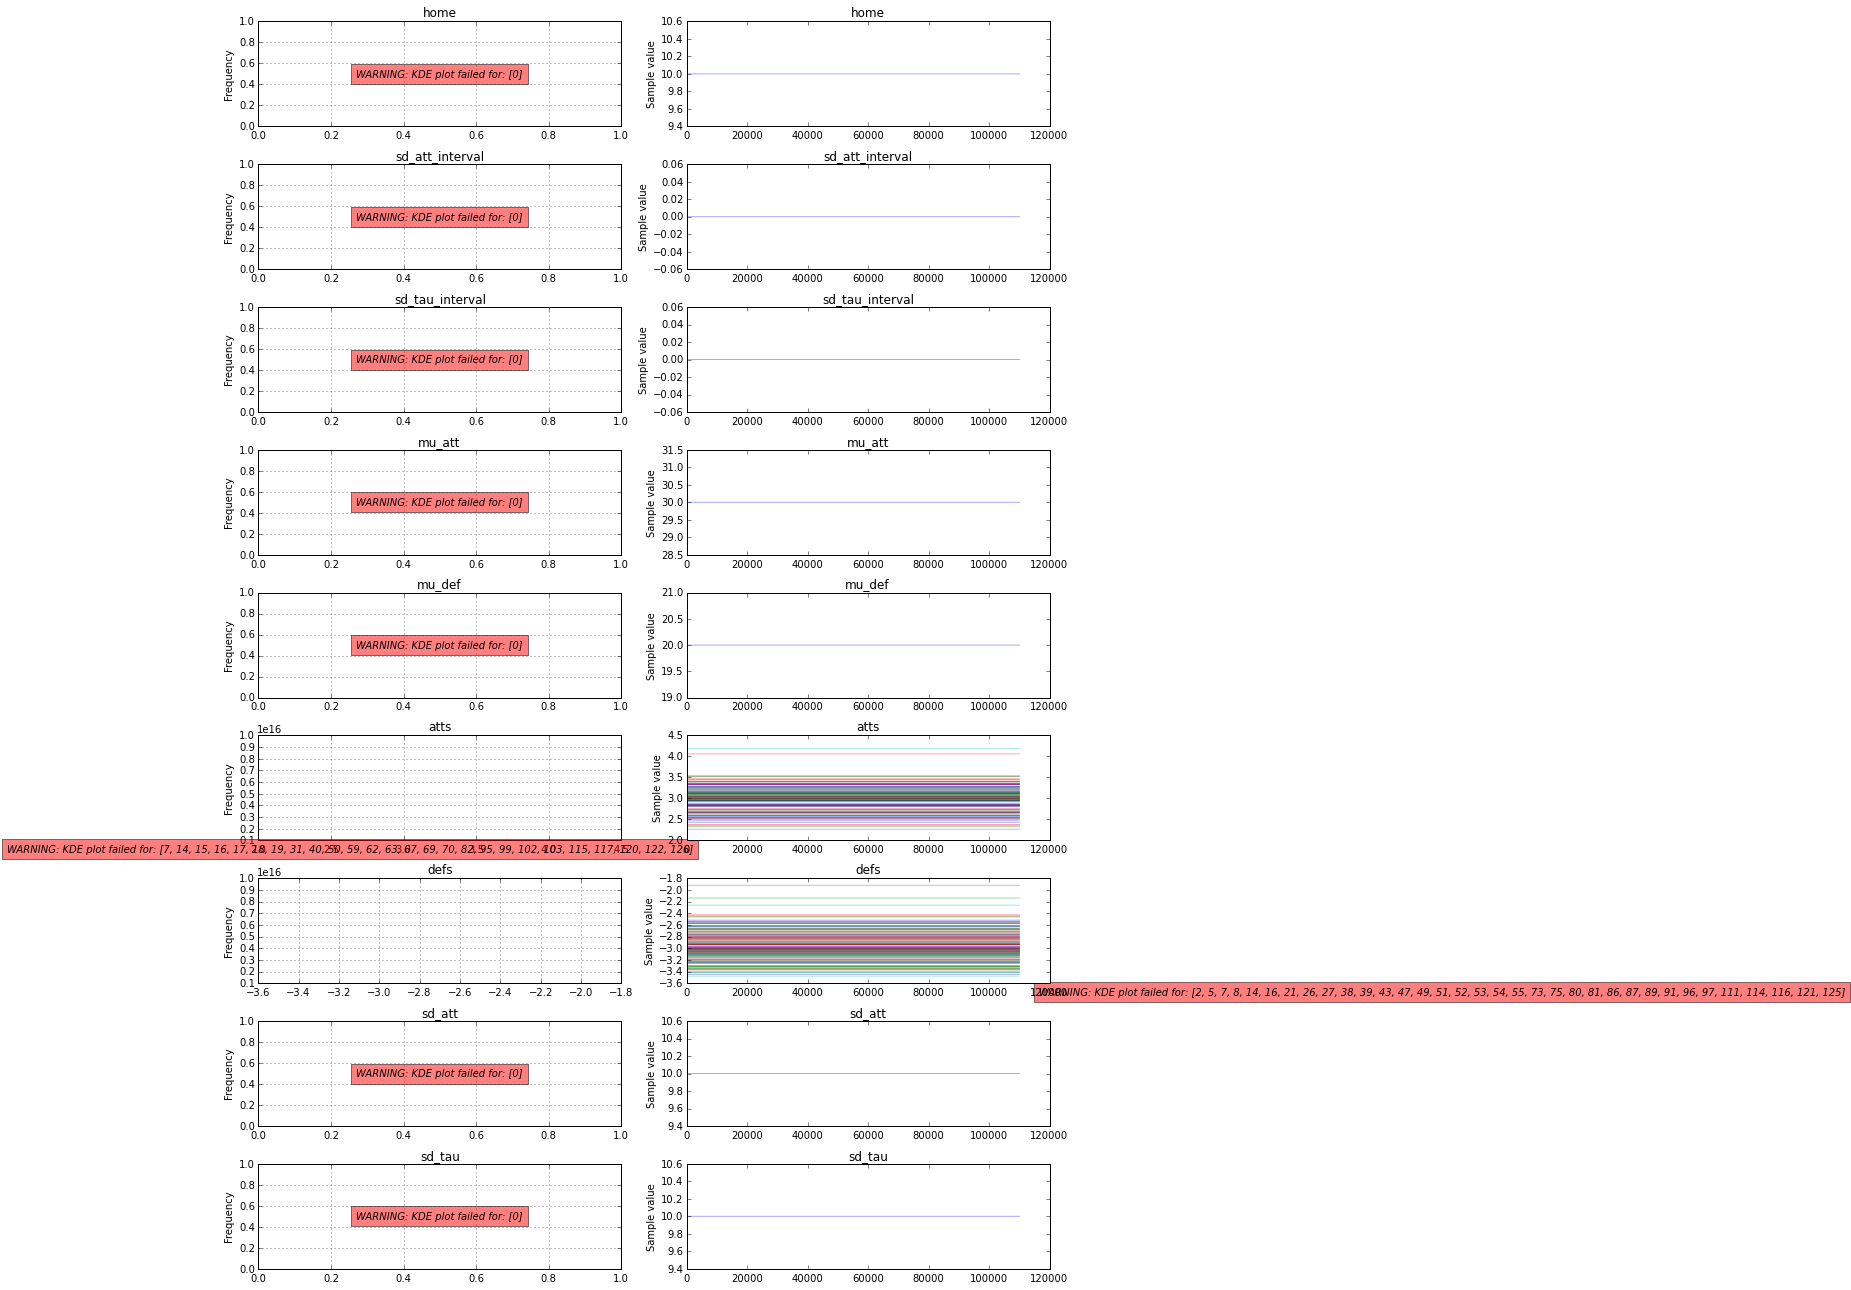

In [243]:
traceplot(trace)